We will use the Industrial Optical Inspection Dataset. 
The blocks given below will help you copy and unzip the data from google drive.

---


The dataset description can be found here : https://hci.iwr.uni-heidelberg.de/node/3616

# Google Colab
Set the Runtime to GPU from the menu on the top left of this webpage

Importing data to Google Colab

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
# Copy data to google colab from google drive and unzip
# This may take 1-2 minutes
!cp gdrive/My\ Drive/optical_data.zip .
!unzip optical_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/Class1/Test/0041.PNG  
  inflating: __MACOSX/data/Class1/Test/._0041.PNG  
  inflating: data/Class1/Test/0055.PNG  
  inflating: __MACOSX/data/Class1/Test/._0055.PNG  
  inflating: data/Class1/Test/0109.PNG  
  inflating: __MACOSX/data/Class1/Test/._0109.PNG  
  inflating: data/Class1/Test/0135.PNG  
  inflating: __MACOSX/data/Class1/Test/._0135.PNG  
  inflating: data/Class1/Test/0121.PNG  
  inflating: __MACOSX/data/Class1/Test/._0121.PNG  
  inflating: data/Class1/Test/0492.PNG  
  inflating: __MACOSX/data/Class1/Test/._0492.PNG  
  inflating: data/Class1/Test/0486.PNG  
  inflating: __MACOSX/data/Class1/Test/._0486.PNG  
  inflating: data/Class1/Test/0479.PNG  
  inflating: __MACOSX/data/Class1/Test/._0479.PNG  
  inflating: data/Class1/Test/0451.PNG  
  inflating: __MACOSX/data/Class1/Test/._0451.PNG  
  inflating: data/Class1/Test/0337.PNG  
  inflating: __MACOSX/data/Class1/Test/._0337.PNG  
  inflating: data/C

In [7]:
# You should be able to see 7 Classes here
!ls data

Class1	Class2	Class3	Class4	Class5	Class6	Class7


Sample Output : Class1 Class2	Class3	Class4	Class5	Class6	Class7

# Main Notebook

In [0]:
import os
import sys
import time
import warnings
from random import shuffle

%tensorflow_version 1.x

import numpy as np
import pandas as pd
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from tensorflow.python.lib.io import file_io
from skimage.transform import resize
import numpy as np
import keras
from keras import backend as K
import cv2
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")


# Data Loading

In [0]:
# Not all data in the dataset has defects. We only use the images which have defects
# This function takes the dataset_type as a parameter. You can pass "Train" or "Test"
# as argument to get the appropriate dataset
def load_data(dataset_type="Train"):
    file_list = {}
    defect_map = {}
    file_name = []
    file_mask = []
    count = 0
    num_classes = 6

    data_dir = "data"
    for x in range(1, num_classes + 1):
        path = os.path.join(os.path.join(data_dir, "Class" + str(x)), dataset_type)
        df = pd.read_fwf(path + "/Label/Labels.txt")
        count = 0
        for i in range(0, len(df)):
            curr_file = path + "/" + str(df.iloc[i][2])
            if (df.iloc[i][1] == 1):
                file_list[curr_file] = path + "/Label/" + str(df.iloc[i][4])
                defect_map[curr_file] = 1
            else:
                fnametest = str(df.iloc[i][2]).split(".")
                file_list[curr_file] = str(path + "/Label/" + fnametest[0] + "_label.PNG")
                defect_map[curr_file] = 0

    items = list(file_list.keys())
    shuffle(items)
    for key in items:
        if ((not os.path.exists(key)) or (not os.path.exists(file_list[key]))):
            # print ("Missing mask for ", key)
            continue

        if defect_map[key] == 1:
            file_name.append(key)
            file_mask.append(file_list[key])
        elif count < 80 * num_classes:
            file_name.append(key)
            file_mask.append(file_list[key])
            count = count + 1

    return file_name, file_mask

Since the dataset is so large that it cannot fit into memory, we will need to use generator functions to iteratively load the dataset

In [0]:
# This is generator class to process data in batches and send them for training
class Surface_Generator(keras.utils.Sequence):

    def __init__(self, image_filenames, labels, batch_size, test=False):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size

    # return the total number of batches you have i.e., total_files/batch_size
    def __len__(self):
        return len(self.image_filenames)//self.batch_size 

    # this function is called for every mini-batch to get the images/masks for that mini-batch
    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        image_arr = []
        mask_arr = []
        # Open a batch of images and their corresponding masks using cv2.imread
        # resize them to 512x512x1 and return an np.array of images and masks
        image_arr = [resize(cv2.imread(img,0),(512,512,1)) for img in batch_x]
        mask_arr = [resize(cv2.imread(msk,0),(512,512,1)) for msk in batch_y]

        return np.array(image_arr).astype(np.float32), np.array(mask_arr).astype(np.float32)
    
    # for testing we need to get the list of all true masks
    # this function should return all the labels in the dataset set 
    # we will call this function only for the "Test" dataset
    def get_all_masks(self):
        mask_arr = [resize(cv2.imread(msk,0),(512,512,1)) for msk in self.labels]

        return np.array(mask_arr).astype(np.float32)


In [0]:
# Since we already have a split for training and test set,
# we just need to split training set to get a validation set

# Load training data
X, Y = load_data("Train")

In [12]:
# Split the original training data to get training and validation set
# to get X_train, X_val, y_train, y_val
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2)


# Convert to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(740,) (740,) (186,) (186,)


The output shape after the split should be 
(740,) (740,) (186,) (186,)

In [13]:
# Free memory
import gc
del X
del Y
gc.collect()

178

# Metrics

Use keras.backend to calculate dice coefficient metric and dice coefficient loss function.

Recall that dice_coeff = 2 \* intersection / union

We add a smoothing parameter and modify the formula to

dice_coeff = 2 \* (intersection + smooth) / (union + smooth)

Our objective is to make dice_coeff as close to 1.0 as possible. 
Define and use the appropriate loss function.

In [0]:
# Dice Coefficient metric
def dice_coef(y_true, y_pred):
    smooth = 1
    true_flat = K.flatten(y_true)
    pred_flat = K.flatten(y_pred)
    intersection = K.sum(true_flat * pred_flat)
    return (2.0 * intersection + smooth) / (K.sum(true_flat) + K.sum(pred_flat) + smooth)


# Dice Coefficient loss
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Model

U-net architeture has proved to be very powerful for segmentation tasks.

We will be creating a Unet model based on the paper : 

[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf)

---

A picture of the architecture we plan to use is provided in the project description pdf.

We will create a Convolutional block module to help us build the model.

Each convolutional block module will contain two trainable layers. 

Each layer will be a Convolution operation followed by batch normalization with relu activation.



The U-net architecture has a contracting path, a convolution and then an expansive path.

We will use instances of the convolutional block to create the contracting and expansive path.

In [0]:
from keras.layers import Conv2DTranspose, Dropout, Activation, BatchNormalization, UpSampling2D, Concatenate
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate
from keras.models import Model

# Create a 2D convolution block. We will use multiple instances of this block to build our U-net model
# This block will contain two layers. 
# Each layer will be a Convolution operation followed by batch normalization with relu activation 
def conv2d_block(input_tensor, n_filters, kernel_size):
    # first layer
    # Create a Conv2D layer with n_filters and a kernel of dimension : kernel_size x kernel_size. 
    # Use same padding and he_normal initializer
    # YOUR CODE HERE
    x = Conv2D(n_filters, (kernel_size, kernel_size), padding = 'same', kernel_initializer = 'he_normal')(input_tensor)
    
    # add a BatchNormalization layer
    # YOUR CODE HERE
    x = BatchNormalization()(x)
        
    # Add a relu non-linearity (keras.layers.Activation)
    # YOUR CODE HERE
    x = Activation('relu')(x)
    
    # second layer
    # repeat the above steps (Conv + batchnorm + relu) taking the output of relu layer as input for this convolutional layer
    # YOUR CODE HERE
    x = Conv2D(n_filters, (kernel_size, kernel_size), padding = 'same', kernel_initializer = 'he_normal')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # return the output tensor
    return x


def get_unet_model(n_filters=16, dropout_prob=0.5, kernel_size=3):
    input_img = Input((512, 512, 1))
    
    # contracting path
    # create a convolutional block with input_img as the input tensor and n_filters
    # YOUR CODE HERE
    c1 = conv2d_block(input_img, n_filters, kernel_size)

    # apply a 2d maxpooling with a pool size of 2x2
    # YOUR CODE HERE
    p1 = MaxPooling2D((2,2))(c1)

    # add a dropout. Since this the input, set the dropout rate to 0.5 * dropout_prob
    # YOUR CODE HERE
    p1 = Dropout(0.5*dropout_prob)(p1)


    # create another convolutional block. this time use p1 as input tensor and twice the n_filters
    # repeat the same maxpool and dropout but set dropout rate to dropout_prob this time
    # YOUR CODE HERE
    c2 = conv2d_block(p1, 2*n_filters, kernel_size)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout_prob)(p2)

    # create another block with maxpool and dropout with 4 x n_filters
    # YOUR CODE HERE
    c3 = conv2d_block(p2, 4*n_filters, kernel_size)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout_prob)(p3)

    # create another block with maxpool and dropout with 8 x n_filters
    # YOUR CODE HERE
    c4 = conv2d_block(p3, 8*n_filters, kernel_size)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout_prob)(p4)


    # This is the layer where we combine the contractive and expansive paths
    # create a convolutional block with 16 x n_filters. No pooling/dropout this time
    # YOUR CODE HERE
    c5 = conv2d_block(p4, 16*n_filters, kernel_size)

    
    # Expansive path

    # We will create a similar structure as the contracting path but instead of 
    # convolutional operation, we will use Deconvolution operations

    # Create a Conv2DTranspose layer (deconvolution) with 8 x n_filters, kernel_size, 
    # 2x2 strides and same padding
    # YOUR CODE HERE
    u6 = Conv2DTranspose(8*n_filters, (kernel_size,kernel_size),strides=(2, 2), padding='same')(c5)

    # Concatenate u6 and c4 using keras.layers.concatenate
    # YOUR CODE HERE
    u6 = concatenate([u6,c4])
    
    # dropout
    # YOUR CODE HERE
    u6 = Dropout(dropout_prob)(u6)
    
    # create a convolutional block with 8 x n_filters
    # YOUR CODE HERE
    c6 = conv2d_block(u6, 8*n_filters, kernel_size)
    

    # Create a similar module as previous, deconv, concatenate, dropout, conv2d_block
    # Please ensure that the number of filters you use match the n_filters of 
    # the layer you are concatenating with
    # YOUR CODE HERE
    u7 = Conv2DTranspose(4*n_filters, (kernel_size,kernel_size),strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7,c3])
    u7 = Dropout(dropout_prob)(u7)
    c7 = conv2d_block(u7, 4*n_filters, kernel_size)
    
    # Create a similar module as previous, deconv, concatenate, dropout, conv2d_block
    # YOUR CODE HERE
    u8 = Conv2DTranspose(2*n_filters, (kernel_size,kernel_size),strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8,c2])
    u8 = Dropout(dropout_prob)(u8)
    c8 = conv2d_block(u8, 2*n_filters, kernel_size)


    # Create a similar module as previous, deconv, concatenate, dropout, conv2d_block
    # YOUR CODE HERE
    u9 = Conv2DTranspose(n_filters, (kernel_size,kernel_size),strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9,c1])
    u9 = Dropout(dropout_prob)(u9)
    c9 = conv2d_block(u9, n_filters, kernel_size)

    # apply a 1x1 convolution on c9 to get an output with a single channel
    # This is the final model output. We want the pixel values in the mask to be
    # either 0 or 1. Choose an activation function which can give values in that
    # range.
    # YOUR CODE HERE
    outputs = Conv2D(1,(1,1), activation='sigmoid')(c9)

    model = Model(inputs=[input_img], outputs=[outputs])

    return model

In [0]:
model_name = "unet"
model = get_unet_model()

In [0]:
batch_size = 8
num_epochs = 50
# Compile the model
model.compile(loss=dice_coef_loss, optimizer=Adam(lr=0.0055), metrics=[dice_coef])

In [0]:
# Create generator objects for training and validation
num_training_samples = len(X_train)
num_validation_samples = len(X_val)
# YOUR CODE HERE
training_batch_generator = Surface_Generator(X_train,y_train,batch_size)
validation_batch_generator = Surface_Generator(X_val,y_val,batch_size)

In [0]:
# OPTIONAL
# callbacks for saving models and early stopping
checkpointer = ModelCheckpoint(model_name + "/weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor=dice_coef, verbose=1,
                               save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [22]:
# Fit model
# This will take ~1.5-2 minutes per epoch on a GPU
stmillis = int(round(time.time() * 1000))
history = model.fit_generator(generator=training_batch_generator,
                    steps_per_epoch=(num_training_samples // batch_size),
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=validation_batch_generator,
                    validation_steps=(num_validation_samples // batch_size),
                    use_multiprocessing=True,
                    workers=5,
                    max_queue_size=1,
                    callbacks=[checkpointer, early_stopping])
endmillis = int(round(time.time() * 1000))
print("Time taken: ", endmillis - stmillis)


Epoch 1/50
92/92 [==============================] - 55s 594ms/step - loss: 0.9007 - dice_coef: 0.0993 - val_loss: 0.9604 - val_dice_coef: 0.0323
Epoch 2/50
92/92 [==============================] - 44s 481ms/step - loss: 0.6299 - dice_coef: 0.3701 - val_loss: 0.9416 - val_dice_coef: 0.0486
Epoch 3/50
92/92 [==============================] - 44s 476ms/step - loss: 0.5451 - dice_coef: 0.4549 - val_loss: 0.3998 - val_dice_coef: 0.4300
Epoch 4/50
92/92 [==============================] - 44s 482ms/step - loss: 0.5260 - dice_coef: 0.4740 - val_loss: 0.2460 - val_dice_coef: 0.4893
Epoch 4/50Epoch 5/50
92/92 [==============================] - 44s 484ms/step - loss: 0.5374 - dice_coef: 0.4626 - val_loss: 0.4569 - val_dice_coef: 0.2546
Epoch 6/50
92/92 [==============================] - 45s 487ms/step - loss: 0.5106 - dice_coef: 0.4894 - val_loss: 0.2444 - val_dice_coef: 0.5138
Epoch 7/50
Epoch 6/50
92/92 [==============================] - 44s 478ms/step - loss: 0.5210 - dice_coef: 0.4790 - val_

In [0]:
# Save the trained weights
model.save(model_name + ".h5")

# Save model config as json
model_json = model.to_json()
with open(model_name + ".json", "w") as json_file:
    json_file.write(model_json)

# Persist the model to your google drive [VERY IMPORTANT]
!cp unet.* gdrive/My\ Drive/

In [24]:
# Confirm if model did get saved
!ls -ltr gdrive/My\ Drive/unet*

-rw------- 1 root root    21536 Apr 16 02:34 'gdrive/My Drive/unet.json'
-rw------- 1 root root 14324264 Apr 16 02:34 'gdrive/My Drive/unet.h5'


In [0]:
# In case you wish to load your saved model
!cp gdrive/My\ Drive/unet* .

model.load_weights("unet.h5")

In [26]:
import gc
gc.collect()

# Load test data in X_test and y_test
X_test, y_test = load_data("Test")
X_test = np.array(X_test)
y_test = np.array(y_test)
print (X_test.shape, y_test.shape)

(454,) (454,)


Output shape should be (454,) (454,)

[OPTIONAL] Shuffle and select 25 elements for quick testing


In [0]:
np.random.seed = 629
p = np.random.permutation(len(X_test))
X_test = X_test[p]
y_test = y_test[p]

# X_test = X_test[:25]
# y_test = y_test[:25]

In [0]:
# Predict using model.predict_generator().
# YOUR CODE HERE
test_data_generator = Surface_Generator(X_test,y_test,1,test=True)
y_pred = model.predict_generator(test_data_generator)

In [29]:
# y_true will have the true masks
y_true = test_data_generator.get_all_masks()
print ("Dice coefficient on test data: ", K.get_value(dice_coef(y_true, y_pred)))

Dice coefficient on test data:  0.39349532


The dice coefficient on test data should be close to 0.7



Visulaizing the mask for a random image

In [0]:
# Convert sigmoid outputs to binary class labels
y_pred[20][y_pred[20] >= 0.5] = 1
y_pred[20][y_pred[20] < 0.5] = 0

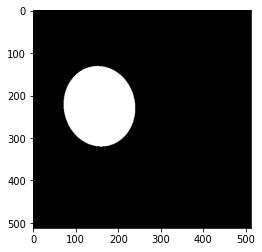

In [31]:
import matplotlib.pyplot as plt
plt.imshow(y_true[20][:,:,0], cmap='gray')
plt.show()

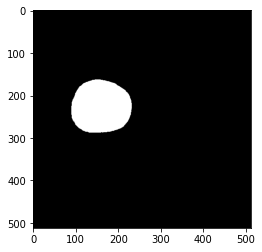

In [32]:
plt.imshow(y_pred[20][:,:,0], cmap='gray')
plt.show()

In [33]:
# Dice coefficient on this example
K.get_value(dice_coef(y_true[20], y_pred[20]))

0.73161995

Data augmentation techniques almost always help in improving the performance of deep learning models.


Try beating the result obtained above by doing some kind of data augmentation and leave the code/results in the jupyter file.

Provide the dice coefficient obtained on the new model trained with data augmentation.

---

# Experimentation Zone
You may write any custom code here. The data augmentation part will be evaluated from this region.

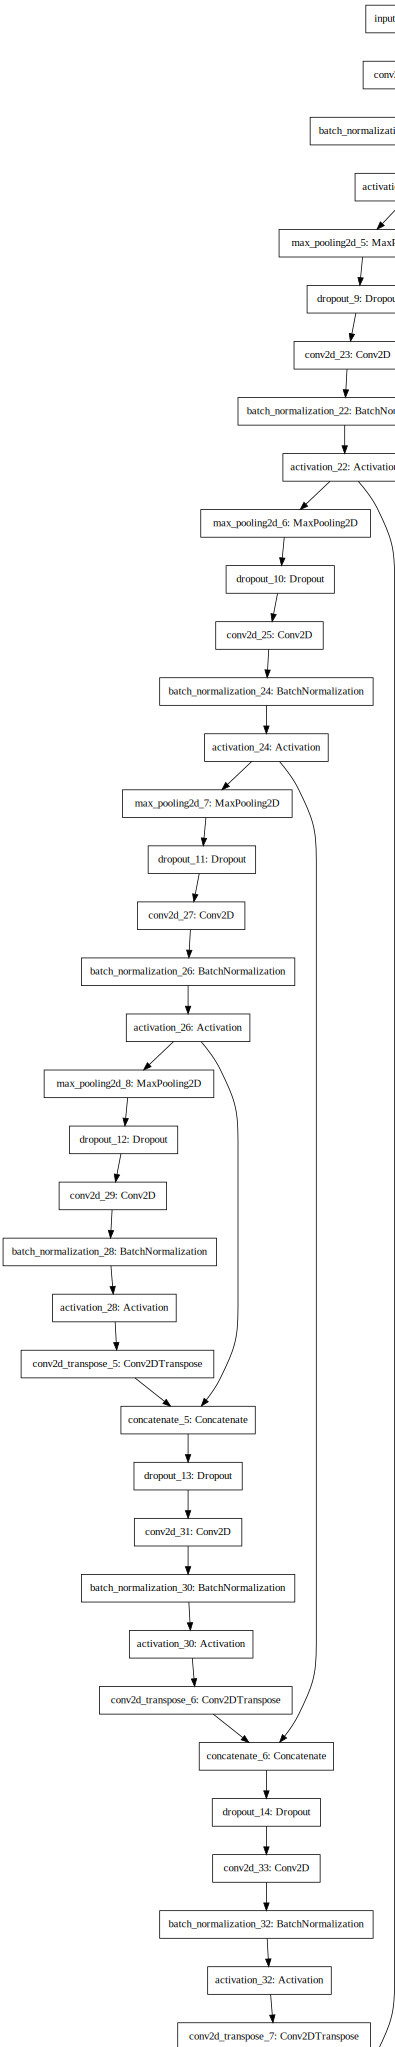

In [37]:
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [39]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 512, 512, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 512, 512, 16) 64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 512, 512, 16) 0           batch_normalization_20[0][0]     
____________________________________________________________________________________________

In [0]:
input_img = Input((512, 512, 1))
    
c10 = conv2d_block(input_img, n_filters=16, kernel_size=3)

In [42]:
type(c10)

tensorflow.python.framework.ops.Tensor

In [43]:
print(c10)

Tensor("activation_38/Relu:0", shape=(?, 512, 512, 16), dtype=float32)


In [0]:
def get_unet_model_test(n_filters=16, dropout_prob=0.5, kernel_size=3):
    input_img = Input((512, 512, 1))
    
    # contracting path
    # create a convolutional block with input_img as the input tensor and n_filters
    # YOUR CODE HERE
    c1 = conv2d_block(input_img, n_filters, kernel_size)

    # apply a 2d maxpooling with a pool size of 2x2
    # YOUR CODE HERE
    p1 = MaxPooling2D((2,2))(c1)

    # add a dropout. Since this the input, set the dropout rate to 0.5 * dropout_prob
    # YOUR CODE HERE
    p1 = Dropout(0.5*dropout_prob)(p1)


    # create another convolutional block. this time use p1 as input tensor and twice the n_filters
    # repeat the same maxpool and dropout but set dropout rate to dropout_prob this time
    # YOUR CODE HERE
    c2 = conv2d_block(p1, 2*n_filters, kernel_size)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout_prob)(p2)

    # create another block with maxpool and dropout with 4 x n_filters
    # YOUR CODE HERE
    c3 = conv2d_block(p2, 4*n_filters, kernel_size)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout_prob)(p3)

    # create another block with maxpool and dropout with 8 x n_filters
    # YOUR CODE HERE
    c4 = conv2d_block(p3, 8*n_filters, kernel_size)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout_prob)(p4)


    # This is the layer where we combine the contractive and expansive paths
    # create a convolutional block with 16 x n_filters. No pooling/dropout this time
    # YOUR CODE HERE
    c5 = conv2d_block(p4, 16*n_filters, kernel_size)

    
    # Expansive path

    # We will create a similar structure as the contracting path but instead of 
    # convolutional operation, we will use Deconvolution operations

    # Create a Conv2DTranspose layer (deconvolution) with 8 x n_filters, kernel_size, 
    # 2x2 strides and same padding
    # YOUR CODE HERE
    u6 = Conv2DTranspose(8*n_filters, (kernel_size,kernel_size),strides=(2, 2), padding='same')(c5)

    # Concatenate u6 and c4 using keras.layers.concatenate
    # YOUR CODE HERE
    u6 = concatenate([u6,c4])
    
    # dropout
    # YOUR CODE HERE
    u6 = Dropout(dropout_prob)(u6)
    
    # create a convolutional block with 8 x n_filters
    # YOUR CODE HERE
    c6 = conv2d_block(u6, 8*n_filters, kernel_size)
    

    # Create a similar module as previous, deconv, concatenate, dropout, conv2d_block
    # Please ensure that the number of filters you use match the n_filters of 
    # the layer you are concatenating with
    # YOUR CODE HERE
    u7 = Conv2DTranspose(4*n_filters, (kernel_size,kernel_size),strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7,c3])
    u7 = Dropout(dropout_prob)(u7)
    c7 = conv2d_block(u7, 4*n_filters, kernel_size)
    
    # Create a similar module as previous, deconv, concatenate, dropout, conv2d_block
    # YOUR CODE HERE
    u8 = Conv2DTranspose(2*n_filters, (kernel_size,kernel_size),strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8,c2])
    u8 = Dropout(dropout_prob)(u8)
    c8 = conv2d_block(u8, 2*n_filters, kernel_size)


    # Create a similar module as previous, deconv, concatenate, dropout, conv2d_block
    # YOUR CODE HERE
    u9 = Conv2DTranspose(n_filters, (kernel_size,kernel_size),strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9,c1])
    u9 = Dropout(dropout_prob)(u9)
    c9 = conv2d_block(u9, n_filters, kernel_size)

    # apply a 1x1 convolution on c9 to get an output with a single channel
    # This is the final model output. We want the pixel values in the mask to be
    # either 0 or 1. Choose an activation function which can give values in that
    # range.
    # YOUR CODE HERE
    outputs = Conv2D(1,(1,1), activation='hard_sigmoid')(c9)
    #sigmoid -- 0.4614
    #tanh -- 0.9032
    #hard_sigmoid -- 0.4197

    model = Model(inputs=[input_img], outputs=[outputs])

    return model

model_name = "unet_test"
model_test = get_unet_model_test()

In [0]:
batch_size = 10
num_epochs = 50
model_test.compile(loss=dice_coef_loss, optimizer=Adam(lr=0.005), metrics=[dice_coef])

In [53]:
num_training_samples = len(X_train)
training_batch_generator = Surface_Generator(X_train,y_train,batch_size)
validation_batch_generator = Surface_Generator(X_val,y_val,batch_size)
stmillis = int(round(time.time() * 1000))
history = model_test.fit_generator(generator=training_batch_generator,
                    steps_per_epoch=(num_training_samples // batch_size),
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=validation_batch_generator,
                    validation_steps=(num_validation_samples // batch_size),
                    use_multiprocessing=True,
                    workers=5,
                    max_queue_size=1,
                    callbacks=[checkpointer, early_stopping])
endmillis = int(round(time.time() * 1000))
print("Time taken: ", endmillis - stmillis)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
74/74 [==============================] - 48s 648ms/step - loss: 0.8981 - dice_coef: 0.1019 - val_loss: 0.9589 - val_dice_coef: 0.0274
Epoch 2/50
74/74 [==============================] - 46s 627ms/step - loss: 0.7439 - dice_coef: 0.2561 - val_loss: 0.9499 - val_dice_coef: 0.0304
Epoch 2/50
Epoch 3/50
74/74 [==============================] - 45s 606ms/step - loss: 0.5797 - dice_coef: 0.4203 - val_loss: 0.8700 - val_dice_coef: 0.0658
Epoch 4/50
74/74 [==============================] - 44s 595ms/step - loss: 0.5683 - dice_coef: 0.4317 - val_loss: 0.4401 - val_dice_coef: 0.3524
Epoch 5/50
74/74 [==============================] - 44s 600ms/step - loss: 0.5328 - dice_coef: 0.4672 - val_loss: 0.3250 - val_dice_coef: 0.4067
Epoch 6/50
74/74 [==============================] - 44s 596ms/step - loss: 0.5246 - dice_coef: 0.4754 - val_loss: 0.8427 - val_dice_coef: 0.0793
Epoch 7/50
74/74 [=======